## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Exploration

In [5]:
df = df.drop('id', axis=1)

In [6]:
df[df['question1'].isnull()]

,qid1,qid2,question1,question2,is_duplicate
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [7]:
df[df['question2'].isnull()]

,qid1,qid2,question1,question2,is_duplicate
105780,174363,174364,How can I develop android app?,NaN,0
201841,303951,174364,How can I create an Android app?,NaN,0


In [8]:
# Remove rows with nulls
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404287 non-null  int64 
 1   qid2          404287 non-null  int64 
 2   question1     404287 non-null  object
 3   question2     404287 non-null  object
 4   is_duplicate  404287 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


In [9]:
# Percent duplicated
df[df['is_duplicate']==1].shape[0] / df.shape[0] * 100

# Data is somewhat bias towards un-duplicated data as it is not 50% split. 

36.92005926482919

In [135]:
df['is_duplicate'].value_counts()[0]

255024

([<matplotlib.patches.Wedge at 0x1ee5513aac0>,
 [Text(-0.4393966626198468, 1.0084297560457747, 'Not duplicated'),
  Text(0.4393966626198465, -1.008429756045775, 'Duplicated')],
 [Text(-0.23967090688355275, 0.5500525942067861, '63%'),
  Text(0.23967090688355258, -0.5500525942067862, '37%')])

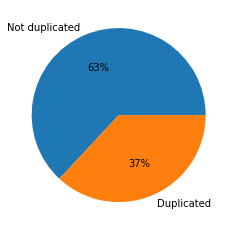

In [136]:
data = [df['is_duplicate'].value_counts()[0], df['is_duplicate'].value_counts()[1]]
plt.pie(data,
        labels = ['Not duplicated','Duplicated'],
        autopct='%.0f%%')

Text(0, 0.5, 'Count')

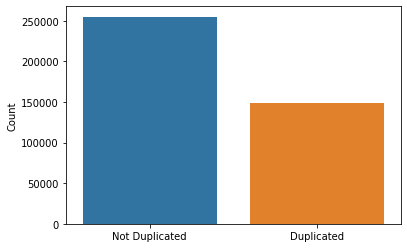

In [138]:
sns.barplot(x=['Not Duplicated', 'Duplicated'], y=data)
plt.ylabel('Count')

([<matplotlib.patches.Wedge at 0x1ee49889e50>,
 [Text(-0.994058518660401, 0.47100707158034205, 'Unique questions'),
  Text(0.9940584966109677, -0.47100711811557894, 'Non-unique questions')],
 [Text(-0.5422137374511278, 0.25691294813473203, '86%'),
  Text(0.5422137254241641, -0.2569129735175885, '14%')])

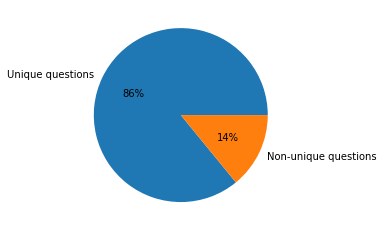

In [102]:
num_unique_qid = len(set(df['qid1'].values + df['qid2'].values))
data = [num_unique_qid, (df.shape[0] - num_unique_qid)]
plt.pie(data,
        labels = ['Unique questions','Non-unique questions'],
        autopct='%.0f%%')

Text(0, 0.5, 'Count')

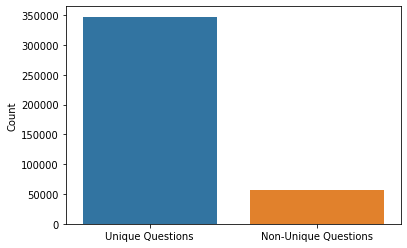

In [133]:
sns.barplot(x=['Unique Questions','Non-Unique Questions'], y=data)
plt.ylabel('Count')

In [117]:
df.groupby('qid1').size().sort_values(ascending=False)

qid1
8461      50
14110     48
1749      47
20628     47
25984     47
          ..
201869     1
201875     1
201877     1
201879     1
537932     1
Length: 290652, dtype: int64

In [123]:
# Most asked question out of qid1
df[df['qid1'] == 8461]['question1'].values[0]

'How do I improve my English speaking?'

In [118]:
df.groupby('qid2').size().sort_values(ascending=False)

qid2
30782     120
2559      115
4044      100
2561       71
17978      66
         ... 
201215      1
201218      1
201220      1
201222      1
537933      1
Length: 299362, dtype: int64

In [122]:
# Most asked question out of qid2
df[df['qid2'] == 30782]['question2'].values[0]

"How can you look at someone's private Instagram account without following them?"

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [11]:
# Add the stopwords where, what, who, how, when as they have significant meaning to question sentences.
question_words = set(['where','what','who','how','when'])
stop_words = set(stopwords.words('english'))
new_stop_words = stop_words - question_words
porter = PorterStemmer()

In [12]:
def text_cleaner(list):
    """
    Returns a clean list that went through tokenization, stopwords removal, punctuation removal, normalization and stemming for each word in the sentence.

    Parameters: 
        list: list of sentences to be cleaned
    
    Returns:
        clean list with stopwords and punctuation removed, normalized and stemming of each word in the sentence 
    """
    clean_list = []
    for item in list:
        tokens = word_tokenize(item)
        tokens = [word.lower() for word in tokens if word.isalnum()]
        tokens = [word for word in tokens if word not in new_stop_words]
        tokens = [porter.stem(word) for word in tokens]
        clean_list.append(' '.join(tokens))
    return clean_list

In [13]:
clean_q1 = text_cleaner(df['question1'].values)
clean_q2 = text_cleaner(df['question2'].values)

In [14]:
df['clean_q1'] = clean_q1
df['clean_q2'] = clean_q2

In [15]:
df[df['is_duplicate'] == 1]

,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,astrolog capricorn sun cap moon cap rise what say,tripl capricorn sun moon ascend capricorn what...
7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,how good geologist,what great geologist
11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1,how read find youtub comment,how see youtub comment
12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1,what make physic easi learn,how make physic easi learn
13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1,what first sexual experi like,what first sexual experi
...,...,...,...,...,...,...,...
404280,537922,537923,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1,what outfit idea wear frat parti,what outfit idea wear frat theme parti
404281,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1,manaphi childish pokémon ranger templ sea,manaphi annoy pokemon ranger templ sea
404282,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1,how long distanc relationship work,how long distanc relationship maintain
404284,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1,what jainism say homosexu,what jainism say gay homosexu


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [16]:
def num_words(list):
    return len(list.split())


In [17]:
# Word count for cleaned version 1 and 2
word_count = []
for sent in df['clean_q1']:
    word_count.append(num_words(sent))
df['q1_word_count'] = word_count

word_count2 = []
for sent in df['clean_q2']:
    word_count2.append(num_words(sent))
df['q2_word_count'] = word_count2

In [18]:
def common_word_cnt(list1, list2):
    counter = 0
    for item in list1:
        if item in list2:
            counter += 1
    return counter

In [19]:
# Number of common words between the two sentences
common_word_count = []
for item in df[['clean_q1','clean_q2']].values:
    common_word_count.append(common_word_cnt(item[0].split(),item[1].split()))

In [20]:
df['common_word_cnt'] = common_word_count
df

,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2,q1_word_count,q2_word_count,common_word_cnt
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what step step guid invest share market india,what step step guid invest share market,8,7,7
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what stori kohinoor diamond,what would happen indian govern stole kohinoor...,4,9,3
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how increas speed internet connect use vpn,how internet speed increas hack dn,7,6,4
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mental lone how solv,find remaind when math 24 divid,4,6,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,10,5,2
...,...,...,...,...,...,...,...,...,...,...
404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,how mani keyword racket program languag latest...,how mani keyword perl program languag latest v...,8,8,7
404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,believ life death,true life death,3,3,2
404287,537928,537929,What is one coin?,What's this coin?,0,what one coin,what coin,3,2,2
404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,what approx annual cost live studi uic chicago...,littl hairfal problem want use hair style prod...,10,13,0


In [21]:
model_df = df[['clean_q1','clean_q2','q1_word_count','q2_word_count','common_word_cnt','is_duplicate']]
model_df

,clean_q1,clean_q2,q1_word_count,q2_word_count,common_word_cnt,is_duplicate
0,what step step guid invest share market india,what step step guid invest share market,8,7,7,0
1,what stori kohinoor diamond,what would happen indian govern stole kohinoor...,4,9,3,0
2,how increas speed internet connect use vpn,how internet speed increas hack dn,7,6,4,0
3,mental lone how solv,find remaind when math 24 divid,4,6,0,0
4,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,10,5,2,0
...,...,...,...,...,...,...
404285,how mani keyword racket program languag latest...,how mani keyword perl program languag latest v...,8,8,7,0
404286,believ life death,true life death,3,3,2,1
404287,what one coin,what coin,3,2,2,0
404288,what approx annual cost live studi uic chicago...,littl hairfal problem want use hair style prod...,10,13,0,0


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [148]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from scipy.sparse import hstack
import scipy

In [23]:
y = model_df['is_duplicate']
X = model_df.drop('is_duplicate',axis=1)


In [149]:
model = xgb.XGBClassifier()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [35]:
def vectorize_questions(train, test):
    vectorizer = TfidfVectorizer(max_features=20000)
    train_vec = vectorizer.fit_transform(train)
    test_vec = vectorizer.transform(test)
    return train_vec, test_vec


In [36]:
cat_data = ['clean_q1','clean_q2']
num_data = ['q1_word_count','q2_word_count','common_word_cnt']

In [37]:
# create the vectorized dataframe for questions
vec_train1, vec_test1 = vectorize_questions(x_train[cat_data[0]], x_test[cat_data[0]])
vec_train2, vec_test2 = vectorize_questions(x_train[cat_data[1]], x_test[cat_data[1]])

train_vec_df = hstack([vec_train1, vec_train2])
test_vec_df = hstack([vec_test1, vec_test2])

In [45]:
# convert to sparse matrix to combine together for the final dataframe
train_sparse = scipy.sparse.csr_matrix(x_train.drop(cat_data, axis=1))
test_sparse = scipy.sparse.csr_matrix(x_test.drop(cat_data, axis=1))

vec_x_train = hstack([train_sparse, train_vec_df])
vec_x_test = hstack([test_sparse, test_vec_df])

In [49]:
model.fit(vec_x_train, y_train)
y_pred = model.predict(vec_x_test)
print(confusion_matrix(y_test, y_pred))

array([[65680, 11075],
       [16023, 28509]], dtype=int64)

In [58]:
print('accuracy: ', accuracy_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))

accuracy:  0.7765795180027538
recall:  0.6401913230935058
precision:  0.720215238480194
f1 score:  0.6778496362166532


In [150]:
param_grid = {'learning_rate': [0.001,0.01,0.1,1],
              'max_depth': [2,5,10,15,25,50]}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(vec_x_train, y_train)
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2}

In [162]:
grid_search.cv_results_['mean_test_score']

array([0.63009894, 0.62997173, 0.62974558, 0.62951237, 0.62869965,
       0.62713428, 0.63012367, 0.63010601, 0.630053  , 0.62995406,
       0.62958304, 0.62856184, 0.63012721, 0.63001413, 0.62968551,
       0.62926855, 0.62811661, 0.62502827, 0.62355124, 0.61654064,
       0.6044523 , 0.59409894, 0.58000707, 0.56320495])

In [154]:
best_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=2)

In [155]:
best_model.fit(vec_x_train, y_train)
y_pred = best_model.predict(vec_x_test)
print(confusion_matrix(y_test, y_pred))

[[76678     8]
 [44595     6]]


In [156]:
print('accuracy: ', accuracy_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))

accuracy:  0.6322524260637991
recall:  0.00013452613170108295
precision:  0.42857142857142855
f1 score:  0.0002689678359296201


In [59]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
f_model = RandomForestClassifier(max_depth = 50, n_estimators=50)
f_model.fit(vec_x_train, y_train)
f_y_pred = f_model.predict(vec_x_test)
print(confusion_matrix(y_test, f_y_pred))

[[74895  1860]
 [31852 12680]]


In [67]:
print('accuracy: ', accuracy_score(y_test, f_y_pred))
print('recall: ', recall_score(y_test, f_y_pred))
print('precision: ', precision_score(y_test, f_y_pred))
print('f1 score: ', f1_score(y_test, f_y_pred))

accuracy:  0.7220477050302175
recall:  0.28473906404383365
precision:  0.8720770288858322
f1 score:  0.4293066088840736


In [68]:
from sklearn import naive_bayes

In [71]:
n_model = naive_bayes.MultinomialNB()
n_model.fit(vec_x_train, y_train)
n_y_pred = n_model.predict(vec_x_test)
print(confusion_matrix(y_test, n_y_pred))

[[65174 11581]
 [17597 26935]]


In [73]:
print('accuracy: ', accuracy_score(y_test, n_y_pred))
print('recall: ', recall_score(y_test, n_y_pred))
print('precision: ', precision_score(y_test, n_y_pred))
print('f1 score: ', f1_score(y_test, n_y_pred))

accuracy:  0.7594301120482821
recall:  0.6048459534716608
precision:  0.6993197632152871
f1 score:  0.6486610153164435


In [191]:
from keras.models import Sequential
from keras import layers
from sklearn.decomposition import TruncatedSVD
from keras.backend import clear_session

In [192]:
svd = TruncatedSVD(100)
svd_x_train = svd.fit_transform(vec_x_train)
svd_x_test = svd.transform(vec_x_test)

In [193]:
input_dim = svd_x_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [195]:
history = model.fit(svd_x_train, y_train,
                    epochs = 10,
                    validation_data=(svd_x_test, y_test),
                    batch_size=50)

Epoch 1/10
5660/5660 [==============================] - 6s 1ms/step - loss: 0.6618 - accuracy: 0.6274 - val_loss: 0.6582 - val_accuracy: 0.6323
Epoch 2/10
5660/5660 [==============================] - 6s 1ms/step - loss: 0.6594 - accuracy: 0.6302 - val_loss: 0.6580 - val_accuracy: 0.6323
Epoch 3/10
5660/5660 [==============================] - 6s 1ms/step - loss: 0.6593 - accuracy: 0.6302 - val_loss: 0.6584 - val_accuracy: 0.6323
Epoch 4/10
5660/5660 [==============================] - 6s 1ms/step - loss: 0.6592 - accuracy: 0.6302 - val_loss: 0.6580 - val_accuracy: 0.6323
Epoch 5/10
5660/5660 [==============================] - 6s 1ms/step - loss: 0.6592 - accuracy: 0.6301 - val_loss: 0.6580 - val_accuracy: 0.6323
Epoch 6/10
5660/5660 [==============================] - 6s 1ms/step - loss: 0.6591 - accuracy: 0.6302 - val_loss: 0.6583 - val_accuracy: 0.6323
Epoch 7/10
5660/5660 [==============================] - 6s 1ms/step - loss: 0.6590 - accuracy: 0.6302 - val_loss: 0.6580 - val_accuracy:

In [196]:
loss, accuracy = model.evaluate(svd_x_train, y_train)
print('Training accuracy: ', accuracy)
loss, accuracy = model.evaluate(svd_x_test, y_test)
print('Test accuracy: ', accuracy)

8844/8844 [==============================] - 6s 708us/step - loss: 0.6588 - accuracy: 0.6302
Training accuracy:  0.6301872730255127
3791/3791 [==============================] - 3s 700us/step - loss: 0.6581 - accuracy: 0.6323
Test accuracy:  0.6322689056396484


In [200]:
y_pred = model.predict(svd_x_test)

3791/3791 [==============================] - 2s 611us/step


In [202]:
y_pred = np.argmax(y_pred, axis=1)

In [203]:
confusion_matrix(y_test, y_pred)

array([[76686,     0],
       [44601,     0]], dtype=int64)

In [204]:
print('accuracy: ', accuracy_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))

accuracy:  0.6322689158772169
recall:  0.0
precision:  0.0
f1 score:  0.0


c:\Users\John\anaconda3\envs\py_test_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
